In [1]:
""" Check if lat/lon change significantly in the files, causing the non-true-orphans problem """
import subprocess
import pandas as pd
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
#import dash  # (version 1.12.0) pip install dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import matplotlib.pylab as plt
import os,sys
import json
import xarray as xr
import numpy as np
import matplotlib.animation as animation
import geopandas as gpd
    
    
import numpy as np 
#from jupyter_dash import JupyterDash
#import dash_bootstrap_components as dbc

#app = dash.Dash(__name__ , external_stylesheets= [dbc.themes.CYBORG])
#app = JupyterDash(__name__, external_stylesheets= [dbc.themes.CYBORG])

In [2]:
def get_orphan(d):
    csv = '../code/output_data/' + d + '_orphans.csv'  
    
    odb_dir = '/raid60/scratch/leo/scratch/era5/odbs/'
    qs='select distinct lat, lon'  #distinct,count(date) 

    
    res = { 'single' : { 'lat':[], 'lon':[], 'file':[] } ,   
            'multi'  : { 'lat':[], 'lon':[], 'file':[] } }
    
    
    lines = open(csv, 'r').readlines()
    tot = len(lines)
    for l in lines:
        sp = l.split(',')
        fn = sp[0]        
        
        fn = odb_dir + '/' + fn
        #print(fn)
        
        rdata=subprocess.check_output(["odb","sql","-q",qs,"-i",fn,'--no_alignment'],stderr=subprocess.DEVNULL)
        data = rdata.decode('utf-8').split('\n')
        #print(rdata)
        #print(data)
        #print(data[1:-1])

        chunk = data[1:-1]
        
        #print(chunk)
        
        if  len(chunk) ==1:
            res['single']['lat'].append(float(chunk[0].split('\t')[0]))
            res['single']['lon'].append(float(chunk[0].split('\t')[1]))
            res['single']['file'].append(fn)
        else:

            lat1, lat2 = float(chunk[0].split('\t')[0]) , float(chunk[-1].split('\t')[0])
            lon1, lon2 = float(chunk[0].split('\t')[1]) , float(chunk[-1].split('\t')[1])
                
            if (abs(lat1-lat2) < 0.5 and abs(lon1-lon2) < 0.5):
                    res['single']['lat'].append(lat1)
                    res['single']['lon'].append(lon1)
                    res['single']['file'].append(fn)

            else:
                    res['multi']['lat'].append([lat1,lat2])
                    res['multi']['lon'].append([lon1,lon2])
                    res['multi']['file'].append(fn)
                    out = open(d+'_changing_coords_lat1lat2_lon1lon2.dat', 'a')
                    lat1,lat2,lon1,lon2 = str(lat1), str(lat2), str(lon1), str(lon2)
                    out.write(fn + '\t' + lat1 + '\t' + lat2 + '\t' + lon1 + '\t' + lon2 + '\n' )

    return res, tot

    

In [3]:
def plot(dataset, res, tot):
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')


    fs = 13
    plt.xlim([-180.,180.])
    plt.ylim([-90.,90.])
        #clb=f.colorbar(c,ax=ax,orientation='horizontal')                                                                                                                                                                                                                                     
        #clb.ax.set_title('{:6.4f}'.format(np.mean(ds[k]).values/43200)+' '+units)                                                                                                                                                                                                            

    """ Loading from geopandas built-in methods """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world.plot(figsize=(10,12))
    WMO.plot( ax=world,  facecolor="none", edgecolor="lightgray", lw = 0.5)


    plotto = plt.scatter( res['single']['lon'], res['single']['lat'] ,  
                         s = 3, color = 'red', 
                         label = 'Orphans '+ str(len(res['single']['lon'])) )
    #plotto = plt.scatter( res['single']['lon'], res['single']['lat'] ,  s = 0.7, color = 'red', label = 'Orphans ' )

    for lon,lat,num in zip(res['multi']['lon'],res['multi']['lat'], range(len(res['multi']['lat']))):
        if num == 1:
            plt.plot( [lon[0],lon[1]], [lat[0],lat[1]], 
                     color = 'lime', 
                     label = 'Changing coords ' + str(len(res['multi']['lon'])))
            #plt.plot( [lon[0],lon[1]], [lat[0],lat[1]], color = 'blue' , label = 'Changing coords ' )

            plt.scatter( [lon[0],lon[1]], [lat[0],lat[1]], 
                        color = 'blue' ,s = 40, )

        else:
            plt.plot( [lon[0],lon[1]], [lat[0],lat[1]], color = 'lime')
            plt.scatter( [lon[0],lon[1]], [lat[0],lat[1]], 
                        color = 'blue', s = 40,)

    #cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
    #cbar.set_label('Number of Records ')

    if dataset == 'rda':
        ds = 'NCAR'
    elif dataset == 'ai_bfr':
        ds = 'BUFR'
    else:
        ds = 'ERA5 ' + dataset 
    plt.title (str(tot) + ' non identified stations of the dataset ' + ds , fontsize = fs)

    plt.legend(fontsize = 12, loc = 'lower left')
    
    #plt.legend(loc = 'lower left', fontsize = 6 ,ncol = 2)
    plt.savefig('Plots/orphans_map_' + dataset + '.png', dpi= 250,   bbox_inches = 'tight' )
    plt.show()
        #plt.close()
    print('Done +++' , d )
    plt.close()

single:  75 

multi:  3 

 *** tot: 78  *** 


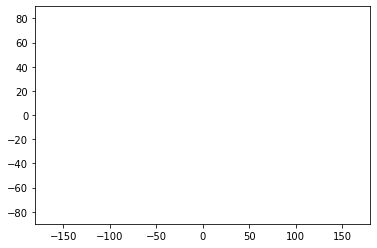

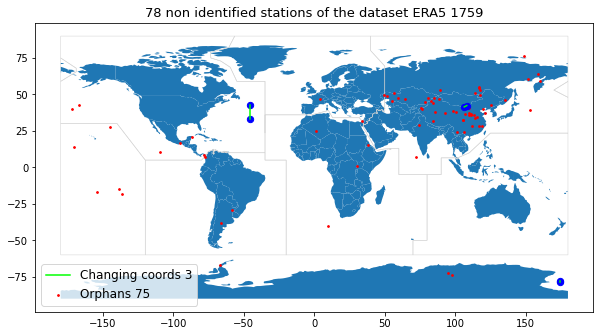

Done +++ 1759
single:  34 

multi:  9 

 *** tot: 43  *** 


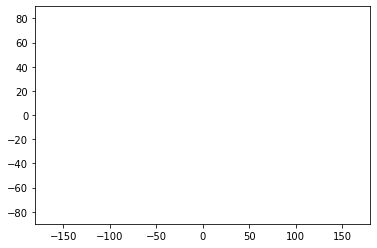

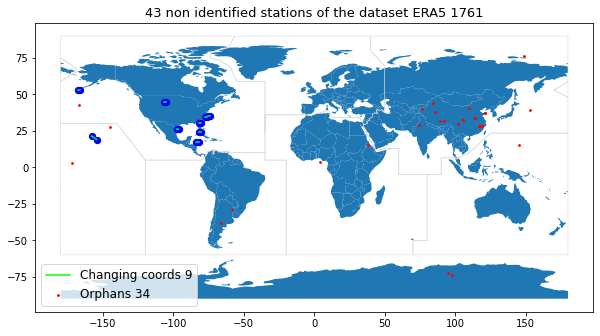

Done +++ 1761
single:  274 

multi:  80 

 *** tot: 354  *** 


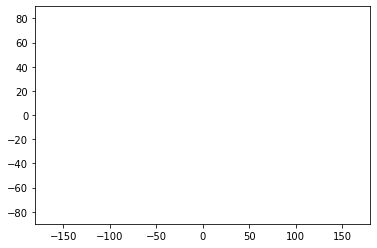

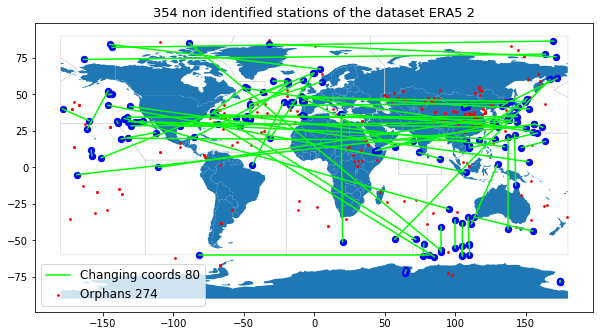

Done +++ 2
single:  139 

multi:  17 

 *** tot: 156  *** 


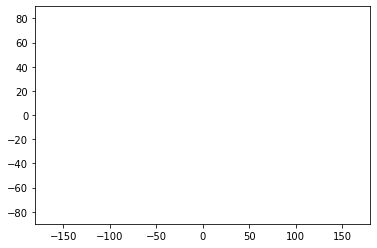

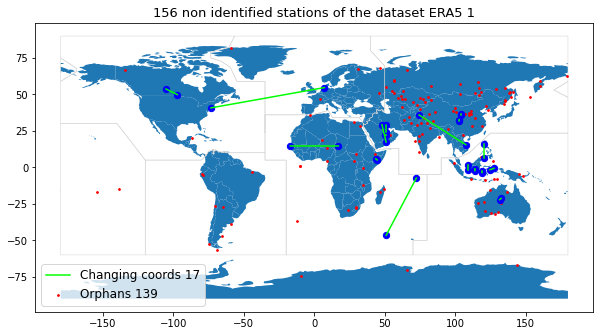

Done +++ 1


In [4]:
#for d in ['1','2','1759','1761','3188']:
#    a = get_orphan(d)

#for d in ['1','2','1759','1761','3188']:
#for d in ['1','2','1759','1761','3188']:
#for d in ['1759','1761','2']:
#        res, tot = get_orphan(d)
        
for d in ['1759','1761','2', '1']:
    try:
        res, tot = get_orphan(d)
        print('single: ', len(res['single']['file']) , '\n')
        print('multi: ', len(res['multi']['file']) , '\n')
        print(' *** tot:' , tot,  ' *** ')
        plot(d, res, tot)
    except:
        print("No orphans for ", d )